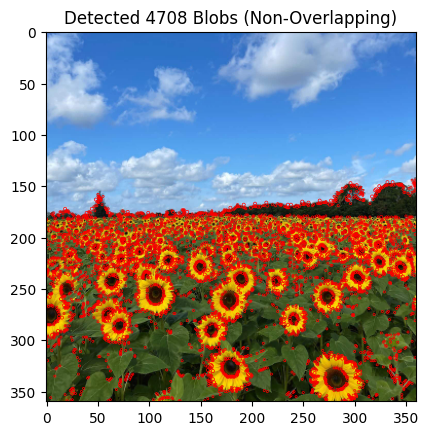

Blob 1: x = 325, y = 194, radius = 1.03, response = 0.25
Blob 2: x = 205, y = 201, radius = 1.03, response = 0.20
Blob 3: x = 187, y = 191, radius = 1.03, response = 0.18
Blob 4: x = 187, y = 190, radius = 1.03, response = 0.18
Blob 5: x = 284, y = 190, radius = 1.03, response = 0.17
Range of sigma values used: [0.5, 0.725, 1.05125, 1.5243125, 2.210253125, 3.2048670312499996, 4.647057195312499, 6.738232933203124]


In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_laplace
from scipy.spatial import cKDTree
import math

class LaplacianBlobDetector:
    def __init__(self, num_scales=10, k=1.25, initial_sigma=1.0, threshold=0.03, overlap=0.5):
        self.num_scales = num_scales  # Number of scales
        self.k = k  # Scale multiplier
        self.initial_sigma = initial_sigma  # Initial scale (sigma)
        self.threshold = threshold  # Threshold for blob detection
        self.overlap = overlap  # Overlap threshold for redundancy elimination

    def compute_scale_space(self, image):
        """Compute the scale space using the Laplacian of Gaussian."""
        h, w = image.shape
        scale_space = np.zeros((self.num_scales, h, w), dtype=np.float64)
        sigma_values = []
        
        for i in range(self.num_scales):
            sigma = self.initial_sigma * (self.k ** i)
            sigma_values.append(sigma)
            log_image = gaussian_laplace(image, sigma) ** 2  # Apply Laplacian of Gaussian and square it
            scale_space[i, :, :] = log_image
        
        return scale_space, sigma_values

    def non_maxima_suppression_3d(self, scale_space):
        """Perform non-maxima suppression in 3D space (across scales and image plane)."""
        h, w = scale_space.shape[1], scale_space.shape[2]
        maxima = np.zeros((h, w), dtype=bool)
        blob_list = []

        for i in range(1, self.num_scales - 1):
            current_scale = scale_space[i]
            prev_scale = scale_space[i - 1]
            next_scale = scale_space[i + 1]

            # Suppress non-maxima in 3D
            local_max = (current_scale > prev_scale) & (current_scale > next_scale)
            local_max &= (current_scale > self.threshold)

            # Record the maxima positions and their corresponding radii (blobs)
            y, x = np.where(local_max)
            for j in range(len(y)):
                radius = np.sqrt(2) * (self.initial_sigma * (self.k ** i))
                blob_list.append((x[j], y[j], radius, current_scale[y[j], x[j]]))
                maxima[y[j], x[j]] = True

        return blob_list

    def detect_blobs(self, image):
        """Main function to detect blobs in the image."""
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_image = gray_image.astype(np.float64) / 255.0

        # Step 1: Compute the scale space
        scale_space, sigma_values = self.compute_scale_space(gray_image)

        # Step 2: Perform 3D non-maxima suppression to detect blobs
        blobs = self.non_maxima_suppression_3d(scale_space)

        # Step 3: Remove overlapping blobs
        filtered_blobs = self.eliminate_overlap(blobs)

        # Sort blobs by response strength (the larger the stronger)
        filtered_blobs = sorted(filtered_blobs, key=lambda x: x[3], reverse=True)

        return filtered_blobs, sigma_values

    def eliminate_overlap(self, blobs):
        """Eliminate overlapping blobs based on the overlap threshold."""
        if len(blobs) < 2:
            return blobs

        # Create an array of (x, y, radius)
        blobs_array = np.array([[b[0], b[1], b[2]] for b in blobs])

        # Calculate distances between all pairs of blobs
        tree = cKDTree(blobs_array[:, :2])
        pairs = list(tree.query_pairs(r=2 * max(blobs_array[:, 2])))  # Check for blobs within twice the radius

        for (i, j) in pairs:
            blob1, blob2 = blobs[i], blobs[j]
            overlap = self.blob_overlap(blob1, blob2)
            if overlap > self.overlap:  # If overlap is greater than the threshold
                # Keep the stronger blob (higher response value)
                if blob1[3] > blob2[3]:
                    blobs[j] = (0, 0, 0, 0)  # Mark blob2 as invalid
                else:
                    blobs[i] = (0, 0, 0, 0)  # Mark blob1 as invalid

        # Filter out marked blobs
        return [b for b in blobs if b[2] > 0]

    def blob_overlap(self, blob1, blob2):
        """Compute the overlap ratio between two blobs."""
        x1, y1, r1, _ = blob1
        x2, y2, r2, _ = blob2

        d = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

        if d > r1 + r2:  # No overlap
            return 0
        elif d <= abs(r1 - r2):  # One blob is inside the other
            return 1
        else:
            # Partial overlap
            ratio1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
            ratio2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
            acos1 = np.arccos(np.clip(ratio1, -1, 1))
            acos2 = np.arccos(np.clip(ratio2, -1, 1))
            area = (r1 ** 2 * acos1 + r2 ** 2 * acos2 - 0.5 * np.sqrt(abs((-d + r2 + r1) * (d + r2 - r1) * (d - r2 + r1) * (d + r2 + r1))))
            return area / (np.pi * min(r1, r2) ** 2)

    def display_blobs(self, image, blobs):
        """Display the detected blobs by drawing circles on the original image."""
        fig, ax = plt.subplots(1)
        ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        for blob in blobs:
            x, y, radius, _ = blob
            circle = plt.Circle((x, y), radius, color='r', fill=False, linewidth=0.5)
            ax.add_patch(circle)
        
        plt.title(f'Detected {len(blobs)} Blobs (Non-Overlapping)')
        plt.show()

    def report_largest_blobs(self, blobs, n=5):
        """Report the parameters of the largest `n` blobs."""
        largest_blobs = blobs[:n]
        for i, blob in enumerate(largest_blobs):
            x, y, radius, response = blob
            print(f"Blob {i+1}: x = {x}, y = {y}, radius = {radius:.2f}, response = {response:.2f}")


# DRIVER CODE
filename = 'images/the_berry_farms_sunflower_field.jpeg'
image = cv2.imread(filename, cv2.IMREAD_REDUCED_COLOR_4)

# Blob detection object with adjusted parameters
blob_detector = LaplacianBlobDetector(num_scales=8, k=1.45, initial_sigma=0.5, threshold=0.01, overlap=0.5)

# Detect blobs in the sunflower image
blobs, sigma_values = blob_detector.detect_blobs(image)

# Display the detected blobs
blob_detector.display_blobs(image, blobs)

# Report parameters of the largest blobs
blob_detector.report_largest_blobs(blobs, n=5)

# Report the sigma values used
print(f"Range of sigma values used: {sigma_values}")


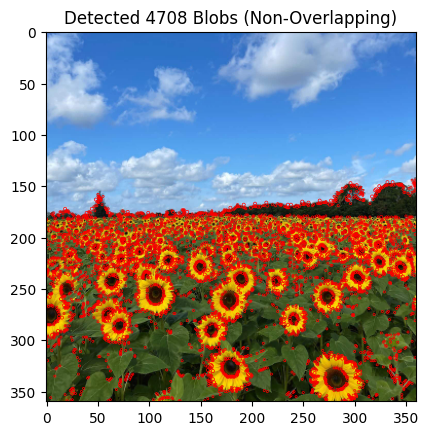

Blob 1: x = 325, y = 194, radius = 1.03, response = 0.25
Blob 2: x = 205, y = 201, radius = 1.03, response = 0.20
Blob 3: x = 187, y = 191, radius = 1.03, response = 0.18
Blob 4: x = 187, y = 190, radius = 1.03, response = 0.18
Blob 5: x = 284, y = 190, radius = 1.03, response = 0.17
Range of sigma values used: [0.5, 0.725, 1.05125, 1.5243125, 2.210253125, 3.2048670312499996, 4.647057195312499, 6.738232933203124, 9.77043775314453, 14.167134742059567]


In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_laplace
from scipy.spatial import cKDTree
import math

class LaplacianBlobDetector:
    def __init__(self, num_scales=10, k=1.25, initial_sigma=1.0, threshold=0.03, overlap=0.5):
        self.num_scales = num_scales  # Number of scales
        self.k = k  # Scale multiplier
        self.initial_sigma = initial_sigma  # Initial scale (sigma)
        self.threshold = threshold  # Threshold for blob detection
        self.overlap = overlap  # Overlap threshold for redundancy elimination

    def compute_scale_space(self, image):
        """Compute the scale space using the Laplacian of Gaussian."""
        h, w = image.shape
        scale_space = np.zeros((self.num_scales, h, w), dtype=np.float64)
        sigma_values = []
        
        for i in range(self.num_scales):
            sigma = self.initial_sigma * (self.k ** i)
            sigma_values.append(sigma)
            log_image = gaussian_laplace(image, sigma) ** 2  # Apply Laplacian of Gaussian and square it
            scale_space[i, :, :] = log_image
        
        return scale_space, sigma_values

    def non_maxima_suppression_3d(self, scale_space):
        """Perform non-maxima suppression in 3D space (across scales and image plane)."""
        h, w = scale_space.shape[1], scale_space.shape[2]
        maxima = np.zeros((h, w), dtype=bool)
        blob_list = []

        for i in range(1, self.num_scales - 1):
            current_scale = scale_space[i]
            prev_scale = scale_space[i - 1]
            next_scale = scale_space[i + 1]

            # Suppress non-maxima in 3D
            local_max = (current_scale > prev_scale) & (current_scale > next_scale)
            local_max &= (current_scale > self.threshold)

            # Record the maxima positions and their corresponding radii (blobs)
            y, x = np.where(local_max)
            for j in range(len(y)):
                # The radius calculation has been adjusted to be proportional to the sigma value
                radius = sqrt(2) * (self.initial_sigma * (self.k ** i))  # More varied radius calculation
                blob_list.append((x[j], y[j], radius, current_scale[y[j], x[j]]))
                maxima[y[j], x[j]] = True

        return blob_list

    def detect_blobs(self, image):
        """Main function to detect blobs in the image."""
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_image = gray_image.astype(np.float64) / 255.0

        # Step 1: Compute the scale space
        scale_space, sigma_values = self.compute_scale_space(gray_image)

        # Step 2: Perform 3D non-maxima suppression to detect blobs
        blobs = self.non_maxima_suppression_3d(scale_space)

        # Step 3: Remove overlapping blobs
        filtered_blobs = self.eliminate_overlap(blobs)

        # Sort blobs by response strength (the larger the stronger)
        filtered_blobs = sorted(filtered_blobs, key=lambda x: x[3], reverse=True)

        return filtered_blobs, sigma_values

    def eliminate_overlap(self, blobs):
        """Eliminate overlapping blobs based on the overlap threshold."""
        if len(blobs) < 2:
            return blobs

        # Create an array of (x, y, radius)
        blobs_array = np.array([[b[0], b[1], b[2]] for b in blobs])

        # Calculate distances between all pairs of blobs
        tree = cKDTree(blobs_array[:, :2])
        pairs = list(tree.query_pairs(r=2 * max(blobs_array[:, 2])))  # Check for blobs within twice the radius

        for (i, j) in pairs:
            blob1, blob2 = blobs[i], blobs[j]
            overlap = self.blob_overlap(blob1, blob2)
            if overlap > self.overlap:  # If overlap is greater than the threshold
                # Keep the stronger blob (higher response value)
                if blob1[3] > blob2[3]:
                    blobs[j] = (0, 0, 0, 0)  # Mark blob2 as invalid
                else:
                    blobs[i] = (0, 0, 0, 0)  # Mark blob1 as invalid

        # Filter out marked blobs
        return [b for b in blobs if b[2] > 0]

    def blob_overlap(self, blob1, blob2):
        """Compute the overlap ratio between two blobs."""
        x1, y1, r1, _ = blob1
        x2, y2, r2, _ = blob2

        d = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

        if d > r1 + r2:  # No overlap
            return 0
        elif d <= abs(r1 - r2):  # One blob is inside the other
            return 1
        else:
            # Partial overlap
            ratio1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
            ratio2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
            acos1 = np.arccos(np.clip(ratio1, -1, 1))
            acos2 = np.arccos(np.clip(ratio2, -1, 1))
            area = (r1 ** 2 * acos1 + r2 ** 2 * acos2 - 0.5 * np.sqrt(abs((-d + r2 + r1) * (d + r2 - r1) * (d - r2 + r1) * (d + r2 + r1))))
            return area / (np.pi * min(r1, r2) ** 2)

    def display_blobs(self, image, blobs):
        """Display the detected blobs by drawing circles on the original image."""
        fig, ax = plt.subplots(1)
        ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        for blob in blobs:
            x, y, radius, _ = blob
            circle = plt.Circle((x, y), radius, color='r', fill=False, linewidth=0.5)
            ax.add_patch(circle)
        
        plt.title(f'Detected {len(blobs)} Blobs (Non-Overlapping)')
        plt.show()

    def report_largest_blobs(self, blobs, n=5):
        """Report the parameters of the largest `n` blobs."""
        largest_blobs = blobs[:n]
        for i, blob in enumerate(largest_blobs):
            x, y, radius, response = blob
            print(f"Blob {i+1}: x = {x}, y = {y}, radius = {radius:.2f}, response = {response:.2f}")

# DRIVER CODE
filename = 'images/the_berry_farms_sunflower_field.jpeg'
image = cv2.imread(filename, cv2.IMREAD_REDUCED_COLOR_4)

# Blob detection object with adjusted parameters
blob_detector = LaplacianBlobDetector(num_scales=10, k=1.45, initial_sigma=0.5, threshold=0.01, overlap=0.5)

# Detect blobs in the sunflower image
blobs, sigma_values = blob_detector.detect_blobs(image)

# Display the detected blobs
blob_detector.display_blobs(image, blobs)

# Report parameters of the largest blobs
blob_detector.report_largest_blobs(blobs, n=5)

# Report the sigma values used
print(f"Range of sigma values used: {sigma_values}")
